In [2]:
import data_loader
from data_loader import load_meshes
import importlib
importlib.reload(data_loader)
from transforms import SDF_transform, rotate, round_to_interval, flatten_index
from pysdf import SDF  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [3]:
final_list = [
    'D:\\Differential rendering\\sparse\\e19bd5905226449ca32354d9b59302fd.glb',
    'D:\\Differential rendering\\sparse\\a4e5e0f3fd3d4af4b6dca5922784acb6.glb',
    'D:\\Differential rendering\\sparse\\teapot.obj',
    'D:\\Differential rendering\\sparse\\torus.obj',
    'D:\\Differential rendering\\sparse\\armchair.obj'

]
obj_list  = load_meshes(final_list)

In [4]:
# grid
size = np.linspace(0, 249, 250)
x, y, z = np.meshgrid(size, size, size)
grid = np.column_stack((x.flatten(), y.flatten(), z.flatten()))
grid = grid.astype(np.int32)
grid

array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [249, 249, 247],
       [249, 249, 248],
       [249, 249, 249]])

In [5]:
d = grid[1][2] -  grid[0][0]
k = int(np.cbrt(len(grid)))
a = grid[0][0]
b = grid[-1][0] + d

d,k,a,b

(1, 250, 0, 250)

In [6]:
num = grid[300: 302]
flatten_index(num, a, b , k)

array([300, 301])

In [7]:
np.round((num[:,1] * k *k) + (num[:,0] * k) + num[:,2]).astype(np.int32)


array([300, 301])

In [8]:
grid[300: 302] 

array([[ 1,  0, 50],
       [ 1,  0, 51]])

In [9]:
sdf_list = []
for obj in obj_list:
    sdf_list.append(SDF(obj.vertices, obj.faces))

sdf_list

[<sdf.SDF(verts.shape=(6096, 3), faces.shape=(10000, 3), robust=True)>,
 <sdf.SDF(verts.shape=(1293, 3), faces.shape=(1490, 3), robust=True)>,
 <sdf.SDF(verts.shape=(3484, 3), faces.shape=(6320, 3), robust=True)>,
 <sdf.SDF(verts.shape=(2304, 3), faces.shape=(1152, 3), robust=True)>,
 <sdf.SDF(verts.shape=(3988, 3), faces.shape=(5588, 3), robust=True)>]

In [10]:
contains_mask_list = []
for sdfs in sdf_list:
    contains_mask_list.append(sdfs.contains(grid))

np.count_nonzero(contains_mask_list[0])

53512

### transform mask and get the sdf

In [19]:
R = [np.pi/8, np.pi/12, np.pi/10]
# R = [0,0,0]
# T = [1, -1, 1]
T = [10, -10 ,10 ]
d = grid[1][2] -  grid[0][0]
k = int(np.cbrt(len(grid)))
a = grid[0][0]
b = grid[-1][0] + d

In [20]:
transformed_sdf_list = SDF_transform(contains_mask_list,R, T, grid)
transformed_sdf_list

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### transform object points, compute the sdf again


In [21]:
new_vertices_list = []
for obj in obj_list:
    new_vertices = obj.vertices
    new_vertices = rotate(new_vertices, R)
    new_vertices = new_vertices + T 
    # new_vertices = round_to_interval(new_vertices, a, b, k)
    new_vertices_list.append(new_vertices)

new_sdf_list = []
for i,obj in enumerate(obj_list):
    new_sdf_list.append(SDF(new_vertices_list[i], obj.faces))

new_contains_mask_list = []
for sdfs in new_sdf_list:
    new_contains_mask_list.append(sdfs.contains(grid))

In [22]:
np.shape(new_contains_mask_list[0])

(15625000,)

In [23]:
np.sum(new_contains_mask_list[0])

53547

In [24]:
theta = [0,0,0]
R = np.array([[np.cos(theta[1])*np.cos(theta[2]),       np.sin(theta[0])*np.sin(theta[1])*np.cos(theta[2]) - np.sin(theta[2])*np.cos(theta[0]),      np.sin(theta[1])*np.cos(theta[0])*np.cos(theta[2]) + np.sin(theta[0])*np.sin(theta[2])],
                  [np.sin(theta[2])*np.cos(theta[1]),       np.sin(theta[0])*np.sin(theta[1])*np.sin(theta[2]) + np.cos(theta[0])*np.cos(theta[2]),      np.sin(theta[1])*np.sin(theta[2])*np.cos(theta[0]) - np.sin(theta[0])*np.cos(theta[2])],
                  [-np.sin(theta[1]),                        np.sin(theta[0])*np.cos(theta[1]),                                                                   np.cos(theta[0])*np.cos(theta[1])]])    

R  

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-0.,  0.,  1.]])

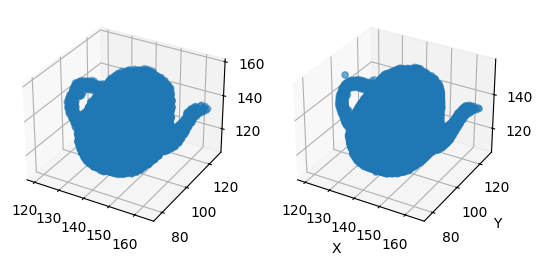

In [25]:
selected_coordinates = grid[transformed_sdf_list[2]]
s2 = grid[new_contains_mask_list[2]]
# Plot the selected coordinates in a 3D scatter plot
s2 = rotate(s2,[0,0, 0])
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(selected_coordinates[:,0], selected_coordinates[:,1], selected_coordinates[:,2])
ax = fig.add_subplot(122, projection='3d')
ax.scatter(s2[:,0], s2[:,1], s2[:,2])
# ax.scatter(s2[:,0], s2[:,1], s2[:,2])
# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

### results

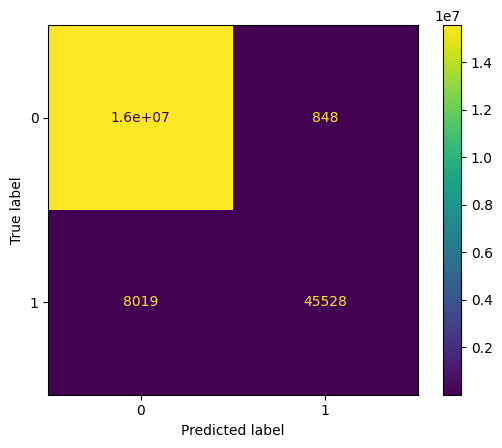

Accuracy for pair 1: 1.00


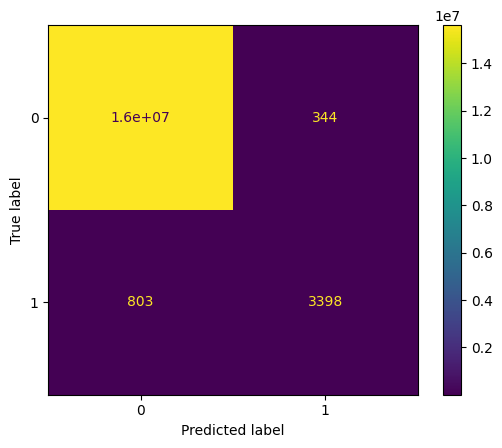

Accuracy for pair 2: 1.00


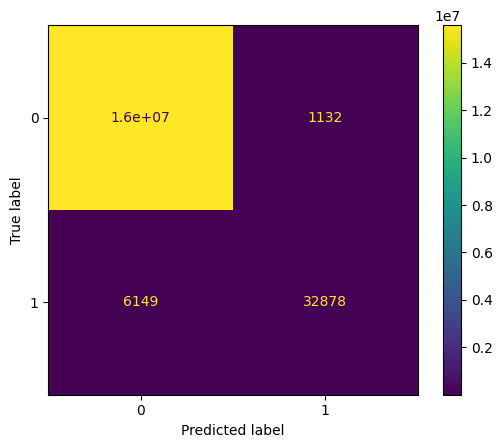

Accuracy for pair 3: 1.00


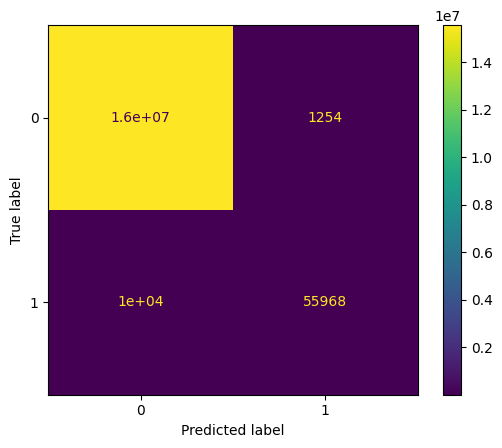

Accuracy for pair 4: 1.00


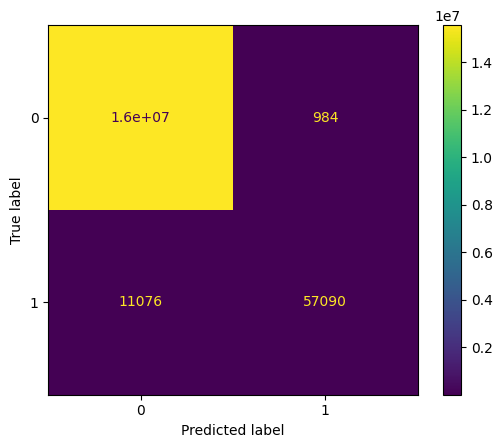

Accuracy for pair 5: 1.00


In [26]:
for i, (label_array, output_array) in enumerate(zip(new_contains_mask_list, transformed_sdf_list)):
    # Calculate confusion matrix
    cm = confusion_matrix(label_array, output_array)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
    # Then just plot it: 
    disp.plot() 
    # And show it: 
    plt.show()
    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Print accuracy
    print(f'Accuracy for pair {i+1}: {accuracy:.2f}')
    
